In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import gc
import re
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [2]:
pd.set_option('display.max_columns', 50)

# データソース  
https://physionet.org/content/challenge-2012/1.0.0/  
Silva I, Moody G, Scott DJ, Celi LA, Mark RG. Predicting In-Hospital Mortality of ICU Patients: The PhysioNet/Computing in Cardiology Challenge 2012. Comput Cardiol (2010). 2012;39:245–248.

Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.

# データの構造

## 入院レコード

set-aにはICU入院ごとに(RecordID).txtのファイルが作られている。  
一つのファイルの中には一般情報と、入院開始から48時間以内に取られたモニターの値、検査値等の時系列情報が記録されている。

In [3]:
sample = pd.read_csv('./set-a/132539.txt')
sample

,Time,Parameter,Value
0,00:00,RecordID,132539.00
1,00:00,Age,54.00
2,00:00,Gender,0.00
3,00:00,Height,-1.00
4,00:00,ICUType,4.00
...,...,...,...
268,47:37,NIMAP,79.33
269,47:37,NISysABP,128.00
270,47:37,RespRate,23.00
271,47:37,Temp,37.80


### 一般情報

以下の6種類  
RecordID (a unique integer for each ICU stay)  
Age (years)  
Gender (0: female, or 1: male)  
Height (cm)  
ICUType (1: Coronary Care Unit, 2: Cardiac Surgery Recovery Unit,3: Medical ICU, or 4: Surgical ICU)  
Weight (kg)*  
(注1)欠損値は-1  
(注2)Weightは時系列情報にも含まれる。体液のバランス把握に使われる為。

In [4]:
sample.query('Time == "00:00"')

,Time,Parameter,Value
0,00:00,RecordID,132539.0
1,00:00,Age,54.0
2,00:00,Gender,0.0
3,00:00,Height,-1.0
4,00:00,ICUType,4.0
5,00:00,Weight,-1.0


### 時系列情報

以下の37種類。定期的に測定されるものと不定期に測定されるものが混在する。  
Albumin (g/dL)  
ALP [Alkaline phosphatase (IU/L)]  
ALT [Alanine transaminase (IU/L)]  
AST [Aspartate transaminase (IU/L)]  
Bilirubin (mg/dL)  
BUN [Blood urea nitrogen (mg/dL)]  
Cholesterol (mg/dL)  
Creatinine [Serum creatinine (mg/dL)]  
DiasABP [Invasive diastolic arterial blood pressure (mmHg)]  
FiO2 [Fractional inspired O2 (0-1)]  
GCS [Glasgow Coma Score (3-15)]  
Glucose [Serum glucose (mg/dL)]  
HCO3 [Serum bicarbonate (mmol/L)]  
HCT [Hematocrit (%)]  
HR [Heart rate (bpm)]  
K [Serum potassium (mEq/L)]  
Lactate (mmol/L)  
Mg [Serum magnesium (mmol/L)]  
MAP [Invasive mean arterial blood pressure (mmHg)]  
MechVent [Mechanical ventilation respiration (0:false, or 1:true)]  
Na [Serum sodium (mEq/L)]  
NIDiasABP [Non-invasive diastolic arterial blood pressure (mmHg)]  
NIMAP [Non-invasive mean arterial blood pressure (mmHg)]  
NISysABP [Non-invasive systolic arterial blood pressure (mmHg)]  
PaCO2 [partial pressure of arterial CO2 (mmHg)]  
PaO2 [Partial pressure of arterial O2 (mmHg)]  
pH [Arterial pH (0-14)]  
Platelets (cells/nL)  
RespRate [Respiration rate (bpm)]  
SaO2 [O2 saturation in hemoglobin (%)]  
SysABP [Invasive systolic arterial blood pressure (mmHg)]  
Temp [Temperature (°C)]  
TropI [Troponin-I (μg/L)]  
TropT [Troponin-T (μg/L)]  
Urine [Urine output (mL)]  
WBC [White blood cell count (cells/nL)]  
Weight (kg)*  

## 転帰

Outcomes-a.txtにはRecordIDごとの転帰が記録されている。  
今回はICU入院後の院内死亡の有無を予測するので、  
In-hospital_death = 0(生存),1(死亡)の2値分類問題を解く

In [5]:
pd.read_csv('Outcomes-a.txt')

,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,132539,6,1,5,-1,0
1,132540,16,8,8,-1,0
2,132541,21,11,19,-1,0
3,132543,7,1,9,575,0
4,132545,17,2,4,918,0
...,...,...,...,...,...,...
3995,142665,19,7,10,336,0
3996,142667,8,2,3,-1,0
3997,142670,8,5,11,-1,0
3998,142671,22,10,8,7,1


# 学習データの作成

## 概要

一つのレコードには48時間分の時系列情報がある。  
12時間ごとにデータを集約し、時間の次元は48/12の4次元とする。  
入力特徴量は時系列情報の37項目に一般情報のAge、Gender、ICUtype、Heightを加えた41次元とする。  
最終的なデータの形状は(レコード数,4,41)の3次元numpy.arrayになる。

In [6]:
time_index = [12,24,36,48]

columns = ['Age', 'Gender', 'Height', 'ICUType', 'Weight', 'Albumin', 'ALP', 'ALT', 'AST',
          'Bilirubin', 'BUN', 'Cholesterol', 'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Glucose',
          'HCO3', 'HCT', 'HR', 'K', 'Lactate', 'Mg', 'MAP', 'MechVent', 'Na', 'NIDiasABP', 'NIMAP',
          'NISysABP', 'PaCO2', 'PaO2', 'pH', 'Platelets', 'RespRate', 'SaO2', 'SysABP', 'Temp',
          'TroponinI', 'TroponinT', 'Urine', 'WBC']

In [7]:
def time_round(hour,time_list):
    #時間をtime_listの時間ごとに丸め込む。今回は12時間ごとに丸め込む予定。
    if hour<time_list[0]:
        return time_list[0]
    elif hour<time_list[1]:
        return time_list[1]
    elif hour<time_list[2]:
        return time_list[2]
    else:
        return time_list[3]

In [8]:
def csv_to_df(file_path):
    '''
    テキストファイルを1つ読み込んで4時間区切り×41項目のデータフレームを返す
    '''
    df_raw = pd.read_csv(file_path)
    
    #時間を12時間ごとに丸め込む
    df_raw['Time'] = df_raw['Time'].str.slice(0,2).astype(int)
    df_raw['Time'] = [time_round(hour,time_list = time_index) for hour in df_raw['Time']]
    
    #新たなデータフレームの作成
    df_new = pd.DataFrame(index=time_index,columns=columns)
        
    for row in df_raw[1:].itertuples(): #最初の一行（RecordID）除き、一行ずつfor文に入れる. row = (index,Time,Parameter,Value)が代入されている。
        time = row[1]
        param = row[2]
        value = row[3]
        #df_newの該当cellに値を代入。同一時間に複数の値があった場合は最後の値が代入される。
        df_new.loc[time,param] = value 
    
    #値を持つcolumnについて、欠損値をまずは前の時間での値で埋める。前に値がない欠損値は後ろ時間での値で埋める。
    df_new = df_new.fillna(axis=0,method='ffill')
    df_new = df_new.fillna(axis=0,method='bfill')
    
    return df_new

In [9]:
csv_to_df('./set-a/132554.txt')

,Age,Gender,Height,ICUType,Weight,Albumin,ALP,ALT,AST,Bilirubin,BUN,Cholesterol,Creatinine,DiasABP,FiO2,GCS,Glucose,HCO3,HCT,HR,K,Lactate,Mg,MAP,MechVent,Na,NIDiasABP,NIMAP,NISysABP,PaCO2,PaO2,pH,Platelets,RespRate,SaO2,SysABP,Temp,TroponinI,TroponinT,Urine,WBC
12,64.0,0.0,-1.0,3.0,60.7,NaN,NaN,NaN,NaN,NaN,21.0,NaN,0.7,NaN,NaN,15.0,113.0,21.0,28.3,133.0,3.9,NaN,1.6,NaN,NaN,139.0,60.0,80.00,120.0,NaN,NaN,NaN,696.0,40.0,NaN,NaN,37.0,NaN,NaN,100.0,15.2
24,64.0,0.0,-1.0,3.0,60.7,NaN,NaN,NaN,NaN,NaN,21.0,NaN,0.7,NaN,NaN,15.0,113.0,21.0,28.3,133.0,3.9,NaN,1.6,NaN,NaN,139.0,68.0,84.67,118.0,NaN,NaN,NaN,696.0,40.0,NaN,NaN,36.9,NaN,NaN,300.0,15.2
36,64.0,0.0,-1.0,3.0,60.7,NaN,NaN,NaN,NaN,NaN,23.0,NaN,0.7,NaN,NaN,15.0,112.0,25.0,28.3,125.0,4.5,NaN,1.7,NaN,NaN,139.0,69.0,93.67,143.0,NaN,NaN,NaN,696.0,36.0,NaN,NaN,36.7,NaN,NaN,200.0,15.2
48,64.0,0.0,-1.0,3.0,60.7,NaN,NaN,NaN,NaN,NaN,23.0,NaN,0.7,NaN,NaN,15.0,112.0,25.0,28.3,122.0,4.5,NaN,1.7,NaN,NaN,139.0,53.0,70.33,105.0,NaN,NaN,NaN,696.0,32.0,NaN,NaN,36.8,NaN,NaN,200.0,15.2


In [10]:
#set-aフォルダの中にある数字6桁.txtというファイルの名前を取り出す。
text_regex = re.compile('\d{6}\.txt')
file_names = text_regex.findall(','.join(os.listdir('./set-a')))
file_names[:5]

['132539.txt', '132540.txt', '132541.txt', '132543.txt', '132545.txt']

In [11]:
df_all = pd.DataFrame(index=[],columns=columns)
#各レコードを縦につなげる
for file_name in tqdm(file_names):
    file_path = os.path.join('./set-a',file_name)
    df = csv_to_df(file_path)
    df_all = pd.concat([df_all,df])

100%|██████████████████████████████████████| 4000/4000 [04:58<00:00, 13.39it/s]


In [12]:
df_all

,Age,Gender,Height,ICUType,Weight,Albumin,ALP,ALT,AST,Bilirubin,BUN,Cholesterol,Creatinine,DiasABP,FiO2,GCS,Glucose,HCO3,HCT,HR,K,Lactate,Mg,MAP,MechVent,Na,NIDiasABP,NIMAP,NISysABP,PaCO2,PaO2,pH,Platelets,RespRate,SaO2,SysABP,Temp,TroponinI,TroponinT,Urine,WBC
12,54.0,0.0,-1.0,4.0,-1.0,NaN,NaN,NaN,NaN,NaN,13.0,NaN,0.8,NaN,NaN,15.0,205.0,26.0,33.5,58.0,4.4,NaN,1.5,NaN,NaN,137.0,40.0,60.33,101.0,NaN,NaN,NaN,221.0,15.0,NaN,NaN,37.6,NaN,NaN,80.0,11.2
24,54.0,0.0,-1.0,4.0,-1.0,NaN,NaN,NaN,NaN,NaN,13.0,NaN,0.8,NaN,NaN,15.0,205.0,26.0,33.5,71.0,4.4,NaN,1.5,NaN,NaN,137.0,41.0,61.67,103.0,NaN,NaN,NaN,221.0,24.0,NaN,NaN,37.1,NaN,NaN,40.0,11.2
36,54.0,0.0,-1.0,4.0,-1.0,NaN,NaN,NaN,NaN,NaN,8.0,NaN,0.7,NaN,NaN,15.0,115.0,28.0,30.3,83.0,4.0,NaN,1.9,NaN,NaN,136.0,49.0,75.67,129.0,NaN,NaN,NaN,185.0,20.0,NaN,NaN,38.2,NaN,NaN,100.0,9.4
48,54.0,0.0,-1.0,4.0,-1.0,NaN,NaN,NaN,NaN,NaN,8.0,NaN,0.7,NaN,NaN,15.0,115.0,28.0,30.3,86.0,4.0,NaN,1.9,NaN,NaN,136.0,55.0,79.33,128.0,NaN,NaN,NaN,185.0,23.0,NaN,NaN,37.8,NaN,NaN,280.0,9.4
12,76.0,1.0,175.3,2.0,76.0,NaN,NaN,NaN,NaN,NaN,16.0,NaN,0.8,61.0,0.4,15.0,105.0,21.0,28.8,80.0,4.3,NaN,3.1,81.0,1.0,139.0,65.0,86.33,129.0,41.0,89.0,7.36,226.0,NaN,97.0,118.0,37.9,NaN,NaN,45.0,7.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,37.0,1.0,-1.0,3.0,87.4,3.1,158.0,1513.0,1277.0,0.6,114.0,NaN,11.7,82.0,0.5,3.0,118.0,21.0,27.1,82.0,5.0,1.9,3.1,98.0,1.0,144.0,NaN,NaN,NaN,44.0,190.0,7.34,314.0,NaN,NaN,145.0,37.4,NaN,NaN,3.0,11.5
12,78.0,0.0,157.5,4.0,70.7,2.2,46.0,28.0,153.0,0.7,17.0,NaN,0.8,53.0,0.6,3.0,126.0,18.0,37.7,96.0,4.9,4.1,2.1,70.0,1.0,144.0,63.0,80.00,135.0,43.0,113.0,7.27,70.0,NaN,97.0,107.0,35.1,NaN,NaN,80.0,11.9
24,78.0,0.0,157.5,4.0,88.8,2.2,46.0,28.0,153.0,0.7,19.0,NaN,1.0,59.0,0.6,8.0,126.0,19.0,37.9,87.0,4.9,1.6,2.5,84.0,1.0,141.0,63.0,80.00,135.0,33.0,113.0,7.33,148.0,NaN,98.0,124.0,37.2,NaN,NaN,33.0,10.2
36,78.0,0.0,157.5,4.0,88.8,2.2,46.0,28.0,153.0,0.7,20.0,NaN,1.4,52.0,0.5,11.0,126.0,19.0,34.6,97.0,4.9,1.9,2.3,73.0,1.0,144.0,63.0,80.00,135.0,40.0,144.0,7.30,148.0,NaN,98.0,103.0,37.7,NaN,NaN,60.0,10.2


## 欠損値補完

In [13]:
#48時間の個別レコード内で一度も記録のない欠損値は、全体の平均で埋める
df_all = df_all.fillna(df_all.mean())

#一般情報の欠損値には-1が入っているので一度Nanに置き換える。なお時系列情報の列には―1は存在しない。
df_all.replace(-1,np.nan,inplace=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 12 to 48
Data columns (total 41 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          16000 non-null  float64
 1   Gender       15988 non-null  float64
 2   Height       8424 non-null   float64
 3   ICUType      16000 non-null  float64
 4   Weight       14816 non-null  float64
 5   Albumin      16000 non-null  float64
 6   ALP          16000 non-null  float64
 7   ALT          16000 non-null  float64
 8   AST          16000 non-null  float64
 9   Bilirubin    16000 non-null  float64
 10  BUN          16000 non-null  float64
 11  Cholesterol  16000 non-null  float64
 12  Creatinine   16000 non-null  float64
 13  DiasABP      16000 non-null  float64
 14  FiO2         16000 non-null  float64
 15  GCS          16000 non-null  float64
 16  Glucose      16000 non-null  float64
 17  HCO3         16000 non-null  float64
 18  HCT          16000 non-null  float64
 19  HR    

性別、身長、体重に欠損値がある。  
性別は最頻値で埋める。  
そのあと性別ごとに身長、体重の中央値で埋める。

In [14]:
df_all['Gender'].fillna(df_all['Gender'].mode()[0],inplace=True)
median_map = df_all.groupby('Gender')[['Height','Weight']].median()
median_map

,Height,Weight
Gender,,
0.0,160.0,71.0
1.0,177.8,85.0


In [15]:
#身長体重を性別ごとに埋める関数。引数はdf_allの各行に対応するシリーズ
def Height_Weight_fill(row_series):
    if row_series.isnull()['Height']:
        if row_series['Gender'] == 0:
            row_series['Height'] = median_map.loc[0,'Height']
        else:
            row_series['Height'] = median_map.loc[1,'Height']
    
    if row_series.isnull()['Weight']:
        if row_series['Gender'] == 0:
            row_series['Weight'] = median_map.loc[0,'Weight']
        else:
            row_series['Weight'] =median_map.loc[1,'Weight']
            
    return row_series

In [16]:
#身長、体重の欠損値を埋める
df_all = df_all.apply(Height_Weight_fill,axis=1)

In [17]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 12 to 48
Data columns (total 41 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          16000 non-null  float64
 1   Gender       16000 non-null  float64
 2   Height       16000 non-null  float64
 3   ICUType      16000 non-null  float64
 4   Weight       16000 non-null  float64
 5   Albumin      16000 non-null  float64
 6   ALP          16000 non-null  float64
 7   ALT          16000 non-null  float64
 8   AST          16000 non-null  float64
 9   Bilirubin    16000 non-null  float64
 10  BUN          16000 non-null  float64
 11  Cholesterol  16000 non-null  float64
 12  Creatinine   16000 non-null  float64
 13  DiasABP      16000 non-null  float64
 14  FiO2         16000 non-null  float64
 15  GCS          16000 non-null  float64
 16  Glucose      16000 non-null  float64
 17  HCO3         16000 non-null  float64
 18  HCT          16000 non-null  float64
 19  HR    

## 標準化

neural netでは入力特徴量の値の幅をそろえる必要があるので、各入力特徴量を標準化する。

In [18]:
df_all_scaled = (df_all-df_all.mean(axis=0))/df_all.std(axis=0)
#MechVentは全て同じ値１で標準化するとNanになるので0にする
df_all_scaled['MechVent'].fillna(0,inplace=True)

In [19]:
df_all_scaled.to_csv('cleaned_set-a.csv')

## データをshape=(4000,4,41)の3次元配列に変更

In [96]:
data = np.zeros((1,4,41)) #for文に入れるの初期値

for i in range(4000):
    array = df_all_scaled.iloc[i*4:(i+1)*4,:].values.reshape(1,4,41)
    data = np.concatenate([data,array],axis=0)
data = np.delete(data,obj=0,axis=0) #初期値として入れていた行を削除

In [97]:
data.shape

(4000, 4, 41)

RNNに投げるデータの整形完了

## 観測の長さの違いを再現

25%のレコード(0:1000)に対しては、最初の24時間のデータを0で埋める。  
これにより、観測時間の長さが違うデータに対して0でpaddingして長さをそろえるという実際の操作を再現できる。

In [98]:
data[0:1000,0:2,:] = 0

# テストデータの作成

In [99]:
outcome = pd.read_csv('Outcomes-a.txt')
outcome.head()

,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,132539,6,1,5,-1,0
1,132540,16,8,8,-1,0
2,132541,21,11,19,-1,0
3,132543,7,1,9,575,0
4,132545,17,2,4,918,0


In [100]:
target = outcome['In-hospital_death'].values
target.shape

(4000,)

In [101]:
target.sum()

554

4000人のICU入院患者中554人が死亡している

# RNN

In [102]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,GRU,LSTM,Flatten,Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

In [103]:
#乱数の固定
import random as rn
np.random.seed(42)

rn.seed(12345)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                        inter_op_parallelism_threads=1)

tf.compat.v1.set_random_seed(1234)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)


In [104]:
x_train,x_val,y_train,y_val = train_test_split(data,target,shuffle=True,test_size=0.2)

In [105]:
model = Sequential()
model.add(LSTM(100,
                    input_shape=(4,41),
                    dropout=0.5,
                    recurrent_dropout=0.5,
                    activation='tanh',
                    kernel_initializer='glorot_normal',
                    recurrent_initializer='orthogonal'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               56800     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 56,901
Trainable params: 56,901
Non-trainable params: 0
_________________________________________________________________


In [106]:
optimizer = optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,amsgrad=True)

model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['AUC'])

es = EarlyStopping(monitor='val_loss',patience=30,verbose=1)

In [107]:
hist = model.fit(x_train,y_train,
                 epochs=1000,batch_size=256,
                 verbose=2,
                 validation_data=(x_val,y_val),
                 callbacks=[es])

Train on 3200 samples, validate on 800 samples
Epoch 1/1000
3200/3200 - 3s - loss: 0.6494 - AUC: 0.6226 - val_loss: 0.5664 - val_AUC: 0.7290
Epoch 2/1000
3200/3200 - 0s - loss: 0.5307 - AUC: 0.7314 - val_loss: 0.4600 - val_AUC: 0.7501
Epoch 3/1000
3200/3200 - 0s - loss: 0.4390 - AUC: 0.7417 - val_loss: 0.3830 - val_AUC: 0.7511
Epoch 4/1000
3200/3200 - 0s - loss: 0.3746 - AUC: 0.7437 - val_loss: 0.3582 - val_AUC: 0.7614
Epoch 5/1000
3200/3200 - 0s - loss: 0.3623 - AUC: 0.7228 - val_loss: 0.3615 - val_AUC: 0.7749
Epoch 6/1000
3200/3200 - 0s - loss: 0.3446 - AUC: 0.7598 - val_loss: 0.3590 - val_AUC: 0.7870
Epoch 7/1000
3200/3200 - 0s - loss: 0.3366 - AUC: 0.7749 - val_loss: 0.3530 - val_AUC: 0.8010
Epoch 8/1000
3200/3200 - 0s - loss: 0.3348 - AUC: 0.7750 - val_loss: 0.3486 - val_AUC: 0.8082
Epoch 9/1000
3200/3200 - 0s - loss: 0.3372 - AUC: 0.7741 - val_loss: 0.3464 - val_AUC: 0.8119
Epoch 10/1000
3200/3200 - 0s - loss: 0.3246 - AUC: 0.7978 - val_loss: 0.3429 - val_AUC: 0.8173
Epoch 11/100

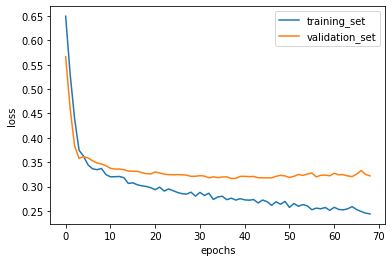

In [108]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(range(len(loss)),loss,label='training_set')
plt.plot(range(len(val_loss)),val_loss,label='validation_set')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

AUC: 0.8455312260373179


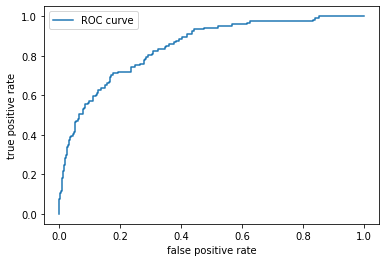

In [109]:
RNN_pred_val = model.predict(x_val)
fpr,tpr,threshold = roc_curve(y_val,RNN_pred_val)
AUC_RNN = roc_auc_score(y_val,RNN_pred_val)

print('AUC:',AUC_RNN)
plt.plot(fpr,tpr,label='ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()

今回の実行環境下ではAUCが0.8を超えるモデルができた。

# RNNではなく全層結合のニューラルネットワークでの性能確認

In [110]:
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape=(4,41)))
mlp_model.add(Dense(200,activation='relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(200,activation='relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(1,activation='sigmoid'))
mlp_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 164)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 200)               33000     
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 201       
Total params: 73,401
Trainable params: 73,401
Non-trainable params: 0
__________________________________________________

In [111]:
optimizer = optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,amsgrad=True)

mlp_model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['AUC'])

es = EarlyStopping(monitor='val_loss',patience=10,verbose=1)

In [112]:
hist = mlp_model.fit(x_train,y_train,
                 epochs=1000,batch_size=256,
                 verbose=2,
                 validation_data=(x_val,y_val),
                 callbacks=[es])

Train on 3200 samples, validate on 800 samples
Epoch 1/1000
3200/3200 - 1s - loss: 0.5146 - AUC: 0.5170 - val_loss: 0.4243 - val_AUC: 0.6489
Epoch 2/1000
3200/3200 - 0s - loss: 0.4154 - AUC: 0.6499 - val_loss: 0.3691 - val_AUC: 0.7433
Epoch 3/1000
3200/3200 - 0s - loss: 0.3880 - AUC: 0.7194 - val_loss: 0.3544 - val_AUC: 0.7721
Epoch 4/1000
3200/3200 - 0s - loss: 0.3516 - AUC: 0.7683 - val_loss: 0.3499 - val_AUC: 0.7843
Epoch 5/1000
3200/3200 - 0s - loss: 0.3290 - AUC: 0.7988 - val_loss: 0.3449 - val_AUC: 0.7938
Epoch 6/1000
3200/3200 - 0s - loss: 0.3251 - AUC: 0.8120 - val_loss: 0.3403 - val_AUC: 0.8034
Epoch 7/1000
3200/3200 - 0s - loss: 0.3224 - AUC: 0.8133 - val_loss: 0.3375 - val_AUC: 0.8078
Epoch 8/1000
3200/3200 - 0s - loss: 0.3065 - AUC: 0.8311 - val_loss: 0.3332 - val_AUC: 0.8143
Epoch 9/1000
3200/3200 - 0s - loss: 0.2977 - AUC: 0.8426 - val_loss: 0.3347 - val_AUC: 0.8144
Epoch 10/1000
3200/3200 - 0s - loss: 0.2922 - AUC: 0.8514 - val_loss: 0.3354 - val_AUC: 0.8134
Epoch 11/100

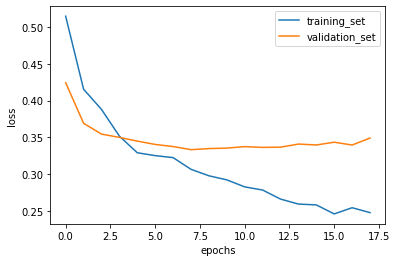

In [113]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(range(len(loss)),loss,label='training_set')
plt.plot(range(len(val_loss)),val_loss,label='validation_set')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

AUC_RNN: 0.8455312260373179 
AUC_mlp: 0.8150050511812461


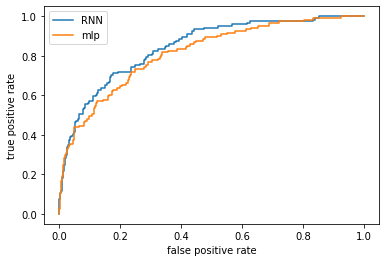

In [114]:
RNN_pred_val = model.predict(x_val)
fpr_RNN,tpr_RNN,_ = roc_curve(y_val,RNN_pred_val)
AUC_RNN = roc_auc_score(y_val,RNN_pred_val)

mlp_pred_val = mlp_model.predict(x_val)
fpr_mlp,tpr_mlp,_ = roc_curve(y_val,mlp_pred_val)
AUC_mlp = roc_auc_score(y_val,mlp_pred_val)

print('AUC_RNN:',AUC_RNN,'\nAUC_mlp:',AUC_mlp)
plt.plot(fpr_RNN,tpr_RNN,label='RNN')
plt.plot(fpr_mlp,tpr_mlp,label='mlp')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()

# AUCの差の検定

私の実行下ではAUCのスコアは全層結合モデルよりもRNNの方が若干良かった。  
このAUCのスコアの差は有意なのか気になったので検定してみた。  
Rを使うと専用のモジュールで計算できるようだが、python用のは見つけられなかったので、自力で実装した。

参考
https://qiita.com/sz_dr/items/96e9306979cb1832d120

In [115]:
from scipy import stats

In [116]:
def psi(a,b):
    if a>b:
        return 1
    elif a==b:
        return 0.5
    else:
        return 0

In [117]:
def calc_V(X,Y,AUC):
    m = len(X)
    n = len(Y)
    
    V1 = 0 #Vの第一項
    for i in range(m):
        sum_psi = 0
        for j in range(n):
            sum_psi += psi(X[i],Y[j])
        sum_psi /= n
        sum_psi -= AUC
        sum_psi = sum_psi**2
        V1 += sum_psi
    V1 /= m*(m-1)
    
    V2 = 0 #Vの第2項
    for j in range(n):
        sum_psi = 0
        for i in range(m):
            sum_psi += psi(X[i],Y[j])
        sum_psi /= m
        sum_psi -= AUC
        sum_psi = sum_psi**2
        V2 += sum_psi
    V2 /= n*(n-1)
    
    return V1+V2

In [118]:
def calc_S_ab(X_a,Y_a,AUC_a,X_b,Y_b,AUC_b):
    m = len(X_a) #=len(X_b)
    n = len(Y_a) #=len(Y_b)のはず
    
    S1 = 0
    for i in range(m):
        sum_psi_a = 0
        for j in range(n):
            sum_psi_a += psi(X_a[i],Y_a[j])
        sum_psi_a /= n
        sum_psi_a -= AUC_a
        
        sum_psi_b = 0
        for j in range(n):
            sum_psi_b += psi(X_b[i],Y_b[j])
        sum_psi_b /= n
        sum_psi_b -= AUC_b
        
        S1 += sum_psi_a*sum_psi_b
        
    S1 /= m*(m-1)


    S2 = 0
    for j in range(n):
        sum_psi_a = 0
        for i in range(m):
            sum_psi_a += psi(X_a[i],Y_a[j])
        sum_psi_a /= m
        sum_psi_a -= AUC_a
        
        sum_psi_b = 0
        for i in range(m):
            sum_psi_b += psi(X_b[i],Y_b[j])
        sum_psi_b /= m
        sum_psi_b -= AUC_b
        
        S2 += sum_psi_a*sum_psi_b
        
    S2 /= n*(n-1)
    
    return S1+S2

In [119]:
result = pd.DataFrame([y_val,RNN_pred_val.reshape(800,),mlp_pred_val.reshape(800,)])

In [120]:
result = result.T
result.columns = ['true','RNN','mlp']

In [121]:
result

,true,RNN,mlp
0,0.0,0.001940,0.002184
1,0.0,0.022023,0.027102
2,1.0,0.049414,0.103625
3,1.0,0.069688,0.015616
4,0.0,0.071166,0.057290
...,...,...,...
795,0.0,0.028078,0.019108
796,0.0,0.023463,0.040059
797,0.0,0.013297,0.063413
798,0.0,0.047828,0.062658


In [122]:
X_RNN = result.query('true==1').RNN.values
Y_RNN = result.query('true==0').RNN.values

X_mlp = result.query('true==1').mlp.values
Y_mlp = result.query('true==0').mlp.values

In [123]:
z = (AUC_RNN-AUC_mlp)/np.sqrt(calc_V(X_RNN,Y_RNN,AUC_RNN)+calc_V(X_mlp,Y_mlp,AUC_mlp)
                              -2*calc_S_ab(X_RNN,Y_RNN,AUC_RNN,X_mlp,Y_mlp,AUC_mlp))
z

2.7626816647421895

帰無仮説 : AUC_RNN=AUC_mlp  
対立仮説 : AUC_RNN>AUC_mlp  
zが標準正規分布に従うという仮定される。有意水準5%で片側検定を行う。

In [124]:
p = 1-stats.norm.cdf(loc=0,scale=1,x=z)
p

0.002866432455928991

帰無仮説は棄却され、RNNと全層結合ニューラルネットワークで予測性能に有意差ありといえる。

# まとめ

RNNを使って時系列医療情報から、ICU入院患者の転帰を予測できた。  
予測性能はAUC:0.8以上で悪くない予測ができている。  
RNNと全層結合のニューラルネットワークとの間でAUCの値に有意な差があった。